<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture06/notebooks/L06_VAE_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Autoencoders Variacionales (VAE)](https://arxiv.org/abs/1906.02691)

Los autoencoders tradicionales comprimen los datos de entrada en un espacio latente de menor dimensión, capturando efectivamente las características más importantes de las imágenes de entrada. Sin embargo, los vectores latentes producidos por los autoencoders tradicionales a menudo carecen de interpretabilidad. Por ejemplo, si consideramos el conjunto de datos MNIST, puede ser difícil entender qué dígitos corresponden a vectores latentes específicos porque los vectores latentes cercanos podrían no representar dígitos similares.

En contraste, cuando se entrenan modelos generativos, es ventajoso tener un espacio latente bien estructurado e interpretable. Aquí es donde entran en juego los **Autoencoders Variacionales (VAE)**.

Un VAE es un tipo de autoencoder que aprende a predecir una *distribución estadística* sobre los parámetros latentes, conocida como la **distribución latente**. Por ejemplo, en un VAE, podríamos suponer que los vectores latentes siguen una distribución Gaussiana

$$
N(\mu_{\mathbf{z}}, e^{\log \sigma_{\mathbf{z}}})
$$

donde $\mu_{\mathbf{z}}$ y $\log \sigma_{\mathbf{z}} \in \mathbb{R}^d$. El codificador en un VAE aprende a predecir estos parámetros de la distribución, y el decodificador reconstruye la entrada muestreando un vector de esta distribución.

Para resumir el proceso de un VAE:

1. A partir de los datos de entrada, el codificador predice $\mu_{\mathbf{z}}$ y $\log \sigma_{\mathbf{z}}$ (predecimos el logaritmo de la desviación estándar en lugar de la desviación estándar en sí por estabilidad numérica).
2. Luego, muestreamos un vector latente $\mathbf{z}_{\text{sample}}$ de la distribución

$$
N(\mu_{\mathbf{z}}, e^{\log \sigma_{\mathbf{z}}})
$$

3. El decodificador intenta reconstruir la entrada original utilizando $\mathbf{z}_\text{sample}}$ como entrada para la red del decodificador.

Este proceso permite que el VAE aprenda un espacio latente suave y continuo donde la interpolación entre puntos en el espacio latente resulta en variaciones significativas en la salida. Esta propiedad hace que los VAE sean particularmente poderosos para generar nuevos datos que son similares a los datos de entrenamiento.

Aquí tienes una representación visual de la arquitectura del VAE:

![Imagen de la arquitectura del VAE](https://drive.google.com/uc?id=1x30qjCzLYIuJJR_dBFDHGolpltYLCCP2)

> Imagen tomada de [este blog](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) de Isaak Dykeman


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

In [17]:
# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

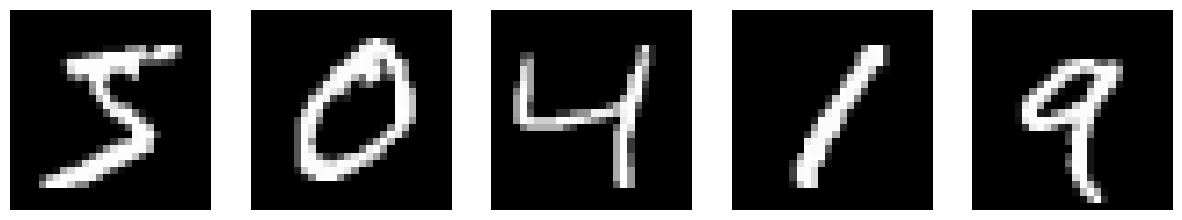

In [3]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n, figsize=(n*3, 3))
    for i, z in enumerate(x[:n]):
        ax[i].imshow(z.reshape(28, 28), cmap='gray')
        ax[i].axis('off')
    plt.show()

plotn(5, x_train)

In [4]:
# Network parameters
latent_dim = 2

encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        401,920 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 534,276 (2.04 MB)

 Trainable params: 534,276 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(784, activation = 'sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,544 (2.04 MB)

 Trainable params: 534,544 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=0
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Los autoencoders variacionales utilizan una función de pérdida compleja que consta de dos partes:

* **Pérdida de reconstrucción**: es la función de pérdida que muestra qué tan cercana es la imagen reconstruida a la original (puede ser MSE). Es la misma función de pérdida que se utiliza en los autoencoders normales.
* **Pérdida KL**, que asegura que las distribuciones de las variables latentes se mantengan cercanas a una distribución normal. Se basa en la noción de la [divergencia de Kullback-Leibler](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained), una métrica para estimar cuán similares son dos distribuciones estadísticas.

In [18]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(x_train, epochs=1, batch_size=128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - kl_loss: 1.7324 - reconstruction_loss: 26.3741 - total_loss: 28.1065


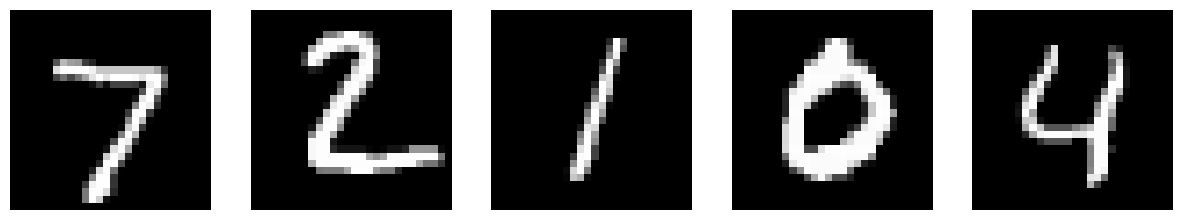

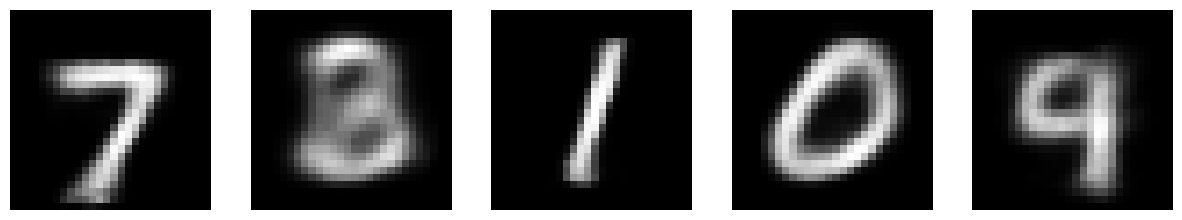

In [25]:
predictions = []
plots = 5
for i, data in enumerate(x_test):
    if i == plots:
        break
    data = np.expand_dims(data, axis=0)
    z_mean, z_log_var = vae.encoder(data)
    z = vae.sampler(z_mean, z_log_var)
    reconstruction = vae.decoder(z)
    predictions.append(reconstruction)
plotn(plots, x_test)
plotn(plots, np.array(predictions))

> **Tarea**: En nuestro ejemplo, hemos entrenado un VAE completamente conectado (fully-connected). Ahora toma la CNN del autoencoder tradicional mencionado anteriormente y crea un VAE basado en CNN.

# Materiales Adicionales

* [Explicación VAE](https://mbernste.github.io/posts/vae/)